### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from preprocess import clahe, sectioning, display_sections, hist_equalization
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

In [3]:
clahed_X1 = clahe(X[1])
hist_X1 = hist_equalization(clahed_X1)
clahhist = clahe(hist_X1)

<function matplotlib.pyplot.show(close=None, block=None)>

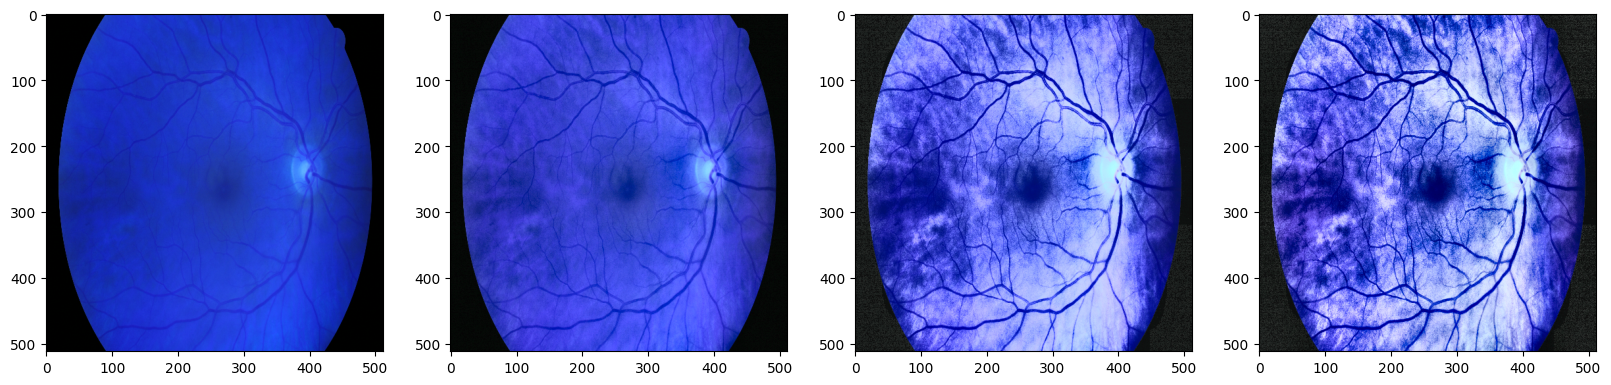

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20,15))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahed_X1, cmap='gray')
ax[2].imshow(hist_X1 , cmap='gray')
ax[3].imshow(clahhist , cmap='gray')
plt.show

In [5]:
N = 64
sections, targets, section_size, target_size = sectioning(X[0], y[0], N, debug=True)

Img padded shape:  (512, 512, 3)
Target padded shape:  (512, 512)


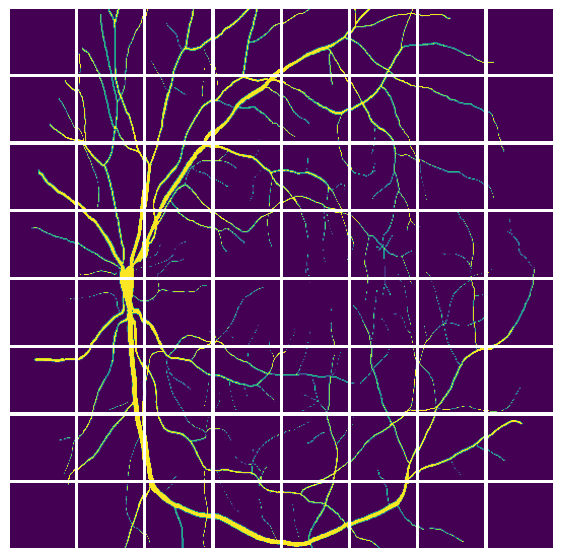

In [6]:
display_sections(targets, target_size, N)

In [7]:
# 5x5
# feature extraction
# colors variation
# central moments
# Hu moments

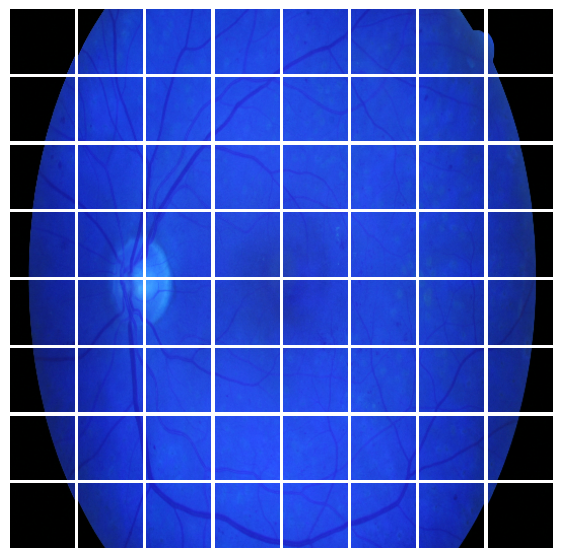

In [8]:
display_sections(sections, section_size, N)

In [9]:
# image -> vector of features
def feature_extraction():
    pass